Current working directory: C:\Users\DELL\Desktop
Training models...
Trained GMM for speaker1
Trained GMM for speaker2
Trained GMM for speaker3
Trained GMM for speaker4
Trained GMM for speaker5

Testing speaker predictions...

Confusion Matrix:
[[1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]

Accuracy: 80.00%
Error Rate: 20.00%


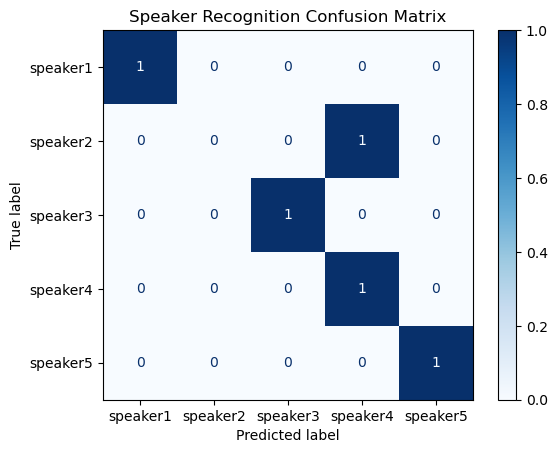


Probe Results:

 probe_1.wav Scores:
  ➤ Score vs speaker1: -52.35
  ➤ Score vs speaker2: -88.72
  ➤ Score vs speaker3: -51.66
  ➤ Score vs speaker4: -89.42
  ➤ Score vs speaker5: -51.45


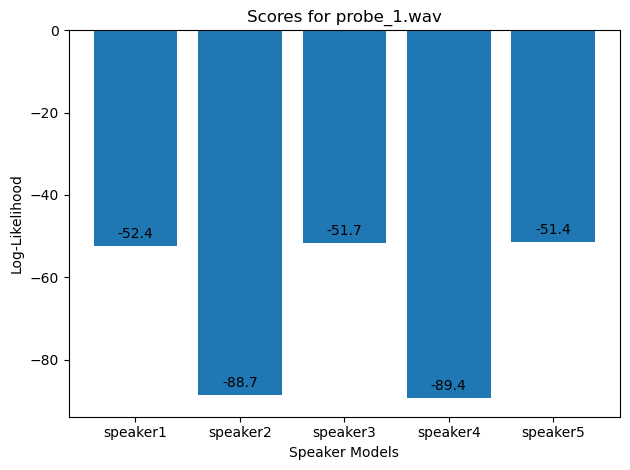


 probe_2.wav Scores:
  ➤ Score vs speaker1: -79.93
  ➤ Score vs speaker2: -62.58
  ➤ Score vs speaker3: -73.27
  ➤ Score vs speaker4: -50.58
  ➤ Score vs speaker5: -75.93


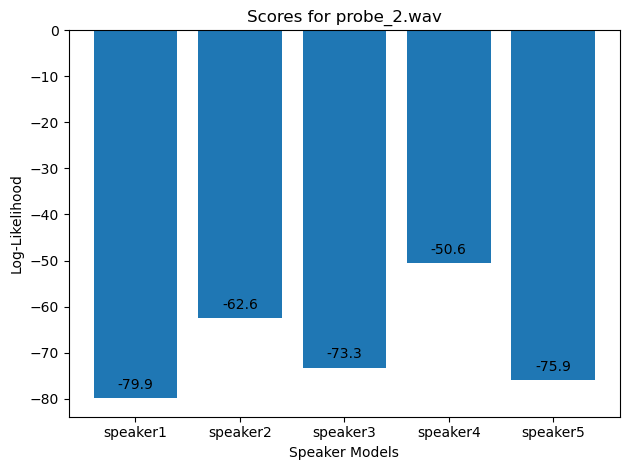

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from python_speech_features import mfcc

# Parameters
n_components = 10
n_mfcc = 13
base_path = './wav-files'  
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')
probe_path = os.path.join(base_path, 'probe')
print("Current working directory:", os.getcwd())

# Step 1: Get speaker list based on filename prefixes
train_files = os.listdir(train_path)
speakers = sorted(set(f.split('_')[0] for f in train_files))

# Step 2: Feature Extraction
def extract_features(filepath):
    sr, signal = wavfile.read(filepath)
    return mfcc(signal, samplerate=sr, numcep=n_mfcc, nfft=2048)

# Step 3: Train GMM Models
speaker_models = {}
print("Training models...")
for speaker in speakers:
    speaker_train_files = [f for f in train_files if f.startswith(speaker)]
    all_features = []
    for filename in speaker_train_files:
        path = os.path.join(train_path, filename)
        feats = extract_features(path)
        all_features.append(feats)
    combined = np.vstack(all_features)
    gmm = GaussianMixture(n_components=n_components, covariance_type='diag', max_iter=200)
    gmm.fit(combined)
    speaker_models[speaker] = gmm
    print(f"Trained GMM for {speaker}")

# Step 4: Testing and Confusion Matrix
print("\nTesting speaker predictions...")
test_files = os.listdir(test_path)
true_labels = []
pred_labels = []

for test_file in test_files:
    path = os.path.join(test_path, test_file)
    features = extract_features(path)
    scores = [model.score(features) for model in speaker_models.values()]
    predicted_index = np.argmax(scores)
    predicted_speaker = list(speaker_models.keys())[predicted_index]
    
    true_speaker = test_file.split('_')[0]
    true_labels.append(true_speaker)
    pred_labels.append(predicted_speaker)

# Create and display confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=speakers)
accuracy = np.trace(cm) / np.sum(cm)
error_rate = 1 - accuracy

print("\nConfusion Matrix:")
print(cm)
print(f"\nAccuracy: {accuracy:.2%}")
print(f"Error Rate: {error_rate:.2%}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=speakers)
disp.plot(cmap='Blues')
plt.title("Speaker Recognition Confusion Matrix")
plt.show()

# Step 5: Probe Validation
print("\nProbe Results:")
probe_files = os.listdir(probe_path)

for probe_file in probe_files:
    path = os.path.join(probe_path, probe_file)
    features = extract_features(path)
    scores = [model.score(features) for model in speaker_models.values()]
    
    print(f"\n {probe_file} Scores:")
    for speaker, score in zip(speaker_models.keys(), scores):
        print(f"  ➤ Score vs {speaker}: {score:.2f}")

    # Bar plot with score labels
    plt.figure()
    bars = plt.bar(speaker_models.keys(), scores)
    plt.title(f"Scores for {probe_file}")
    plt.ylabel("Log-Likelihood")
    plt.xlabel("Speaker Models")

    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width() / 2, score + 2, f"{score:.1f}", ha='center')

    plt.tight_layout()
    plt.show()

In [2]:
# Step 6: Threshold & Summary Enhancements 
SCORE_THRESHOLD = -50.0  
#All test scores are above -50.0
#All probe scores are below -50.0

# Track false accepts and true rejections from probe validation
false_accepts = 0
true_rejects = 0

print("\nThreshold-based Evaluation of Probe Results:")
for probe_file in probe_files:
    path = os.path.join(probe_path, probe_file)
    features = extract_features(path)
    scores = [model.score(features) for model in speaker_models.values()]
    max_score = max(scores)
    best_match = list(speaker_models.keys())[np.argmax(scores)]

    if max_score >= SCORE_THRESHOLD:
        print(f" {probe_file} was incorrectly accepted as {best_match} (score: {max_score:.2f})")
        false_accepts += 1
    else:
        print(f" {probe_file} was correctly rejected (score: {max_score:.2f})")
        true_rejects += 1

# Final probe summary
print("\nProbe Summary with Threshold:")
print(f"True Rejections: {true_rejects}")
print(f"False Acceptances: {false_accepts}")

# Optional: Summary of test predictions
print("\nTest Prediction Summary:")
for true, pred in zip(true_labels, pred_labels):
    status = "Correct" if true == pred else "Incorrect"
    print(f"{true} → {pred} ({status})")



Threshold-based Evaluation of Probe Results:
 probe_1.wav was correctly rejected (score: -51.45)
 probe_2.wav was correctly rejected (score: -50.58)

Probe Summary with Threshold:
True Rejections: 2
False Acceptances: 0

Test Prediction Summary:
speaker1 → speaker1 (Correct)
speaker2 → speaker4 (Incorrect)
speaker3 → speaker3 (Correct)
speaker4 → speaker4 (Correct)
speaker5 → speaker5 (Correct)



Max Scores for Test (Known) Samples:
speaker1_test.wav: Max Score = -47.11 | Predicted = speaker1 | True = speaker1
speaker2_test.wav: Max Score = -49.58 | Predicted = speaker4 | True = speaker2
speaker3_test.wav: Max Score = -49.42 | Predicted = speaker3 | True = speaker3
speaker4_test.wav: Max Score = -50.81 | Predicted = speaker4 | True = speaker4
speaker5_test.wav: Max Score = -49.59 | Predicted = speaker5 | True = speaker5


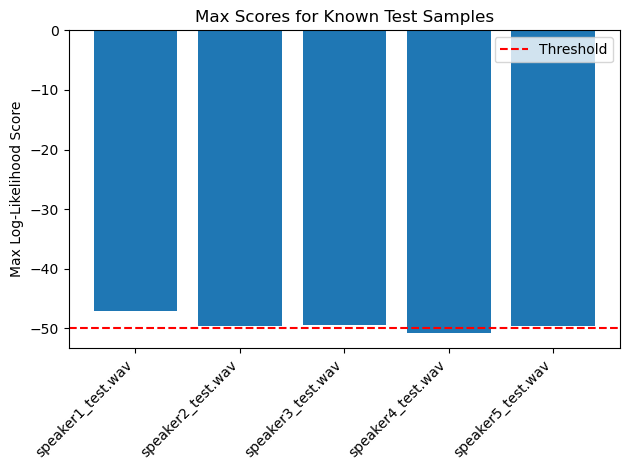

In [3]:
# Step 7: Analyze max scores for test (known) samples
print("\nMax Scores for Test (Known) Samples:")

test_scores = []
for test_file in test_files:
    path = os.path.join(test_path, test_file)
    features = extract_features(path)
    scores = [model.score(features) for model in speaker_models.values()]
    max_score = max(scores)
    test_scores.append(max_score)
    
    predicted_speaker = list(speaker_models.keys())[np.argmax(scores)]
    true_speaker = test_file.split('_')[0]

    print(f"{test_file}: Max Score = {max_score:.2f} | Predicted = {predicted_speaker} | True = {true_speaker}")

# Visualize test scores
plt.figure()
plt.bar(range(len(test_scores)), test_scores)
plt.axhline(SCORE_THRESHOLD, color='red', linestyle='--', label='Threshold')
plt.xticks(range(len(test_scores)), test_files, rotation=45, ha='right')
plt.ylabel("Max Log-Likelihood Score")
plt.title("Max Scores for Known Test Samples")
plt.legend()
plt.tight_layout()
plt.show()


Known Speakers - Mean: -49.30, Std: 1.20
Probe Speakers - Mean: -51.01, Std: 0.43


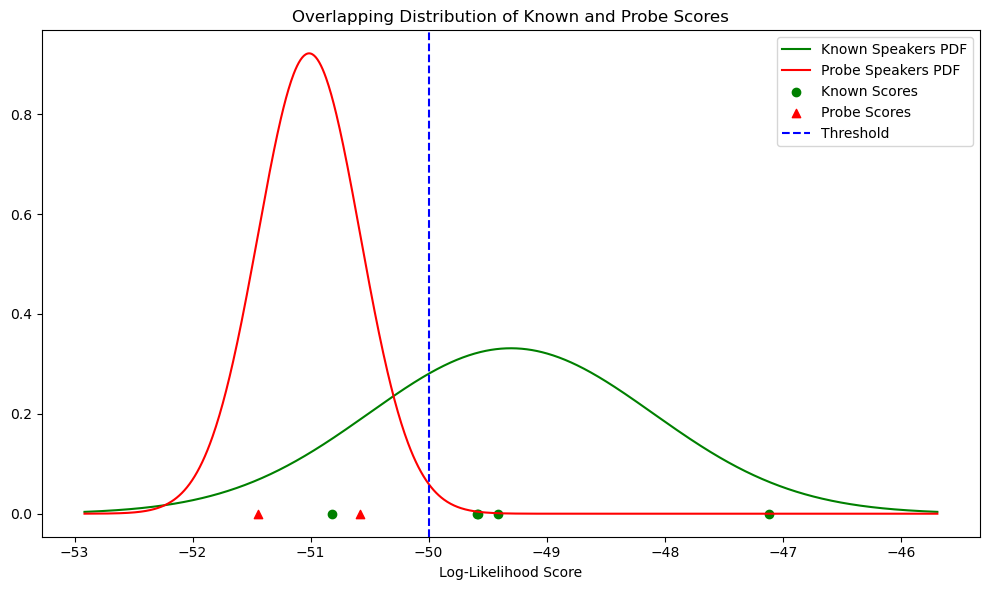

In [4]:
# Overlapping Distribution Plot

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Convert the known test scores into a NumPy array
aScores = np.array(test_scores)  # Known speaker (test) scores

# Collect probe scores for all probe files
pScores = []
for probe_file in probe_files:
    path = os.path.join(probe_path, probe_file)
    features = extract_features(path)
    scores = [model.score(features) for model in speaker_models.values()]
    pScores.append(max(scores))
pScores = np.array(pScores)  # Probe scores

# Calculate the mean and standard deviation for both score sets
aMu, aStd = np.mean(aScores), np.std(aScores)
pMu, pStd = np.mean(pScores), np.std(pScores)

print(f"Known Speakers - Mean: {aMu:.2f}, Std: {aStd:.2f}")
print(f"Probe Speakers - Mean: {pMu:.2f}, Std: {pStd:.2f}")

# Define a unified x-axis range covering both distributions
all_min = min(aMu - 3 * aStd, pMu - 3 * pStd)
all_max = max(aMu + 3 * aStd, pMu + 3 * pStd)
x = np.linspace(all_min, all_max, 1000)

# Compute PDFs for known (authentic) and probe scores
auth_pdf = norm.pdf(x, loc=aMu, scale=aStd)
probe_pdf = norm.pdf(x, loc=pMu, scale=pStd)

# Plot overlapping distributions
plt.figure(figsize=(10, 6))
plt.plot(x, auth_pdf, 'g', label='Known Speakers PDF')
plt.plot(x, probe_pdf, 'r', label='Probe Speakers PDF')

# Overlay actual scores as scatter plots
plt.scatter(aScores, np.zeros(len(aScores)), c='g', marker='o', label='Known Scores')
plt.scatter(pScores, np.zeros(len(pScores)), c='r', marker='^', label='Probe Scores')

# Draw the threshold line
plt.axvline(SCORE_THRESHOLD, color='blue', linestyle='--', label='Threshold')

plt.title("Overlapping Distribution of Known and Probe Scores")
plt.xlabel("Log-Likelihood Score")
plt.legend()
plt.tight_layout()
plt.show()


EER Threshold: -50.57, EER: 10.00%


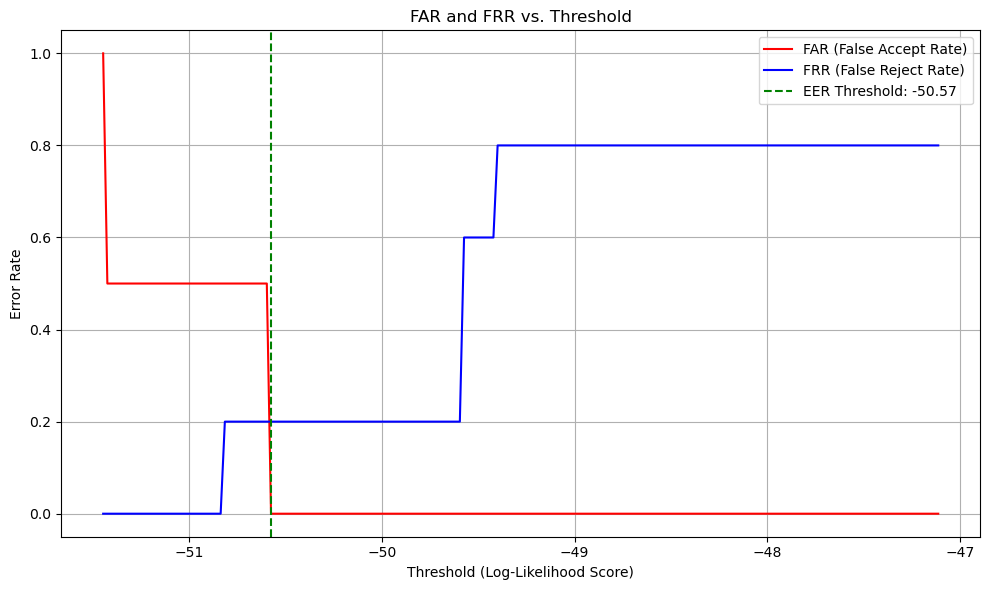

In [6]:
# Generate FAR-FRR Graph

import numpy as np
import matplotlib.pyplot as plt

# Gather Known (Test) scores as a NumPy array (from cell 3)
aScores = np.array(test_scores)  # Known speaker scores

# Gather Probe scores across all probe files
pScores = []
for probe_file in probe_files:
    path = os.path.join(probe_path, probe_file)
    features = extract_features(path)
    scores = [model.score(features) for model in speaker_models.values()]
    pScores.append(max(scores))
pScores = np.array(pScores)  # Probe (impostor) scores

# Define a range of threshold values that spans your score space.
# Adjust the min/max values if needed.
min_threshold = min(np.min(aScores), np.min(pScores))
max_threshold = max(np.max(aScores), np.max(pScores))
thresholds = np.linspace(min_threshold, max_threshold, 200)

# Initialize lists to store FAR and FRR for each threshold.
FAR = []  # False Accept Rate: probe scores that exceed threshold.
FRR = []  # False Reject Rate: known scores that fall below threshold.

for t in thresholds:
    # FAR: Proportion of probe samples with score >= threshold.
    far = np.sum(pScores >= t) / len(pScores)
    # FRR: Proportion of known samples with score < threshold.
    frr = np.sum(aScores < t) / len(aScores)
    
    FAR.append(far)
    FRR.append(frr)

# Convert to NumPy arrays for further processing.
FAR = np.array(FAR)
FRR = np.array(FRR)

# Compute Equal Error Rate (EER) as the threshold where FAR and FRR are closest.
eer_index = np.argmin(np.abs(FAR - FRR))
eer_threshold = thresholds[eer_index]
EER = (FAR[eer_index] + FRR[eer_index]) / 2.0

print(f"EER Threshold: {eer_threshold:.2f}, EER: {EER*100:.2f}%")

# Plot FAR and FRR vs. Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, FAR, 'r-', label="FAR (False Accept Rate)")
plt.plot(thresholds, FRR, 'b-', label="FRR (False Reject Rate)")
plt.axvline(eer_threshold, color='green', linestyle='--', label=f'EER Threshold: {eer_threshold:.2f}')
plt.xlabel("Threshold (Log-Likelihood Score)")
plt.ylabel("Error Rate")
plt.title("FAR and FRR vs. Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
